Wright-Fisher evolution.  
Put equations here at some point

In [1]:
import numpy as np
import numba

## Wright Fisher stochastic discrete time model ##
def CNVsimulator_simpleWF(N, s_snv, m_snv, generation, seed=None, **kwargs):
    """ CNV evolution simulator
    Simulates CNV and SNV evolution for 267 generations
    Returns proportion of the population with a CNV for generations observed in Lauer et al. 2018 as 1d np.array of length 25
    
    Parameters
    -------------------
    N : int
        population size  
    s_snv : float
        fitness benefit of SNVs  
    m_snv : float 
        probability mutation to SNV   
    generation : np.array, 1d 
        with generations 0 through the end of simulation
    seed : int
    
    Depending on what the downstream inference is, the following parameters are can be passed
    cnv_params : np.array, 1d of length dim_param
        Parameter vector with the log 10 selection coefficient and log 10 cnv mutation rate, for use with SNPE or to build observed data
    parameters : instance of parameters
        has attribute s, float, log 10 selection coefficient
        has attribute m, float, log 10 cnv mutation rate
        for use with pyABC
    """
    cnv_params = kwargs.get('cnv_params', None)
    parameters = kwargs.get('parameters', None)
    
    if seed is not None:
        np.random.seed(seed=seed)
    else:
        np.random.seed()

    
    assert N > 0
    N = np.uint64(N)
    if isinstance(cnv_params, np.ndarray):
        s_cnv, m_cnv = np.power(10,cnv_params)
    else:
        s_cnv = np.power(10,parameters.s)
        m_cnv = np.power(10,parameters.m)
    
    w = np.array([1, 1 + s_cnv, 1 + s_snv])
    S = np.diag(w)
    
    # make transition rate array
    M = np.array([[1 - m_cnv - m_snv, 0, 0],
                [m_cnv, 1, 0],
                [m_snv, 0, 1]])
    assert np.allclose(M.sum(axis=0), 1)
    
    # mutation and selection
    E = M @ S

    # rows are genotypes
    n = np.zeros(3)
    n[0] = N  
    
    # follow proportion of the population with CNV
    # here rows with be generation, columns (there is only one) is replicate population
    p_cnv = []
    
    # run simulation to generation 267
    for t in generation:    
        p = n/N  # counts to frequencies
        p_cnv.append(p[1])  # frequency of CNVs
        p = E @ p.reshape((3, 1))  # natural selection + mutation        
        p /= p.sum()  # rescale proportions
        n = np.random.multinomial(N, np.ndarray.flatten(p)) # random genetic drift
    
    #these were the generations observed in Lauer et al. 2018, so the ones we will use here
    exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])
    
    return np.transpose(p_cnv)[exp_gen]

In [3]:
N=3e8
generation = np.array(range(0,268))
s_snv=0.002  # Venkataram et al. 2016
m_snv=1.67e-10 #SNV mutation rate: 1.67 x 10^-10 per base per generation (Zhu et al. 2014)
cnv_params =np.array([np.log10(0.1), np.log10(1e-5)])
cnv_data = CNVsimulator_simpleWF(N, s_snv, m_snv, generation, seed=None, cnv_params=cnv_params)
exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])

No handles with labels found to put in legend.


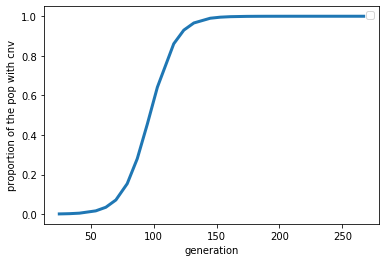

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(exp_gen, cnv_data, lw=3)
ax.set_xlabel('generation')
ax.set_ylabel('proportion of the pop with cnv')
ax.legend()